In [101]:
#circular inference model
import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
# import pystan
%matplotlib inline

In [102]:
def function(L,w):
    f = np.log((w*np.exp(L)+1-w) / ((1-w)*np.exp(L)+w))
    return f

In [103]:
def circular_inference(prior, left_lik,right_lik,param):

    pa1 = param[0]
    pa2 = param[1]
    pa3 = param[2]
    pa4 = param[3]

    #prior logit
    Cp = prior/100
    Fp = 1 - prior/100
    Lp = np.log(Cp/Fp)
    aplp = pa3*Lp
    Faplpwp = function(aplp,pa1)

    #likelihood logit
    Cr = left_lik/100
    Cr_oppo = right_lik/100
    Ls = np.log(Cr/Cr_oppo)
    asls = pa4*Ls
    Faslsws = function(asls,pa2)

    Lc = function(Ls+Faplpwp+Faslsws,pa2) + function(Lp+Faslsws+Faplpwp,pa1)
    pred_c = np.exp(Lc)/(1+np.exp(Lc))

    pred_c = np.clip(pred_c,0.018,0.982)
    

    return pred_c, Lc

In [104]:
data, image_data = preprocessing.preprocess()

/Users/shuhei/Desktop/workspace/model-based/jupyter notebook suteru/preprocessing.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'scz' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[0:n_scz*100,df.columns.get_loc('group')] = 'scz'
/Users/shuhei/Desktop/workspace/model-based/jupyter notebook suteru/preprocessing.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.23809523809524' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_image.at[i,'correct_rate'] = df[df.imgseq == i+1].correct_rate.mean()
/Users/shuhei/Desktop/workspace/model-based/jupyter notebook suteru/preprocessing.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.72727272727

In [107]:
likelihood_dir = '/Users/shuhei/Desktop/workspace/behavior/new_likelihood.csv'
like_data = pd.read_csv(likelihood_dir)

# print(like_data)
like_data['categ1_ave']
for i in range(1,101):
    data.loc[data['imgseq']==i,'correct_image'] = like_data.loc[like_data['im_number']==i,'categ1_ave'].values[0]
    data.loc[data['imgseq']==i,'false_image'] = like_data.loc[like_data['im_number']==i,'categ2_ave'].values[0]
    
# print(like_data.loc[like_data['im_number']==1,'categ1_ave'].values[0])
    
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [6]:
data

,posterior,corloc,prior,imgseq,slider,subject,group,correct_rate,congruency,correct_image,correct_image_for_left,blur,false_image
0,30.0,2.0,30.0,99.0,9.0,0,scz,70.0,70.0,18.571429,22.380952,25.0,18.571429
1,10.0,1.0,90.0,32.0,10.0,0,scz,10.0,90.0,21.428571,52.380952,20.0,62.857143
2,50.0,1.0,50.0,40.0,2.0,0,scz,50.0,50.0,44.285714,40.952381,30.0,45.714286
3,90.0,2.0,90.0,22.0,11.0,0,scz,10.0,10.0,87.142857,40.952381,25.0,12.857143
4,10.0,2.0,10.0,34.0,7.0,0,scz,90.0,90.0,18.571429,43.333333,20.0,61.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,30.0,1.0,30.0,66.0,7.0,20,control,30.0,30.0,54.285714,42.380952,30.0,62.857143
2096,0.0,2.0,70.0,20.0,8.0,20,control,100.0,30.0,70.000000,30.476190,10.0,20.000000
2097,0.0,2.0,10.0,57.0,5.0,20,control,100.0,90.0,61.428571,29.047619,25.0,32.857143
2098,10.0,2.0,10.0,10.0,5.0,20,control,90.0,90.0,30.000000,45.714286,40.0,40.000000


/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_82404/2876518815.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


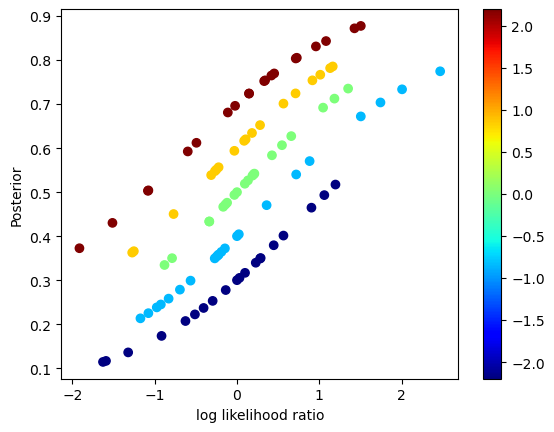

In [7]:
sub_list = []
# number_sub = 21
number_sub=1
sigma = 0
for subject_number in range(number_sub):
#     print(subject_number)
    sub_data = data[data['subject']==subject_number]
    prior_list = np.zeros(100)
    left_like_lis = np.zeros(100)
    right_like_lis = np.zeros(100)
    c_list = np.zeros(100)

    for trial in range(100):
        prior_list[trial] = sub_data.at[(100*subject_number)+trial,'prior']
        
        #likelihood depends on the corloc
        if sub_data.at[(100*subject_number)+trial,'corloc']==1:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
        elif sub_data.at[(100*subject_number)+trial,'corloc']==2:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']

        c_list[trial] = sub_data.at[(100*subject_number)+trial,'posterior']

    prior_list = [n/100 for n in prior_list]
    left_like_lis = [n/100 for n in left_like_lis]
    right_like_lis = [n/100 for n in right_like_lis]
    c_list = [1 if c==0 else c for c in c_list]
    c_list = [99 if c==100 else c for c in c_list]
    c_list = [n/100 for n in c_list]

    wp = 0.75
    ws = 0.9
    alpha_p = 0
    alpha_s = 0
    params = [wp,ws,alpha_p,alpha_s]
    c_estimated = np.zeros(100)
    Lc = np.zeros(100)
    for t in range(100):
        c_estimated[t], Lc[t] = circular_inference(prior_list[t]*100,left_like_lis[t]*100,right_like_lis[t]*100,params)
    
#     plt.plot(likelihood_list,c_estimated)

    prior_ratio = [np.log(prior/(1-prior)) for prior in prior_list]
    like_ratio = [np.log(left/right) for left, right in zip(left_like_lis,right_like_lis)]

    cm = plt.cm.get_cmap('jet')
    plt.scatter(like_ratio,c_estimated,c=prior_ratio,cmap=cm)
    plt.colorbar()
    plt.xlabel('log likelihood ratio')
    plt.ylabel('Posterior')
    plt.show()

/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_82404/3504682535.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(0, 0.5, 'Posterior')

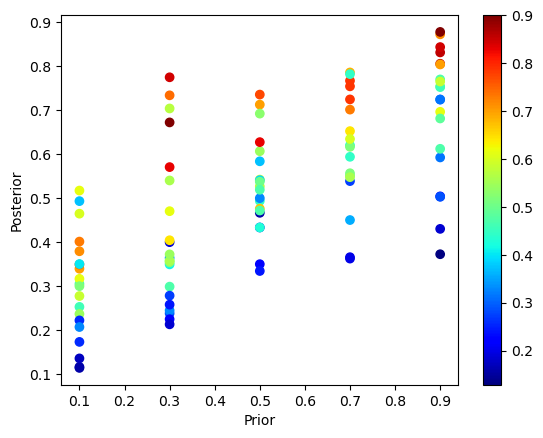

In [8]:
cm = plt.cm.get_cmap('jet')
plt.scatter(prior_list,c_estimated,c=left_like_lis,cmap=cm)
plt.colorbar()
plt.xlabel('Prior')
plt.ylabel('Posterior')

/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_82404/1096715234.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(0, 0.5, 'Posterior')

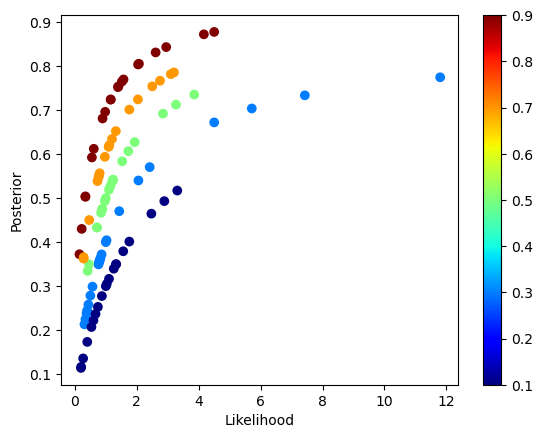

In [9]:
# log_prior = np.log(prior_1)
cm = plt.cm.get_cmap('jet')
plt.scatter(np.array(left_like_lis)/np.array(right_like_lis),c_estimated,c=prior_list,cmap=cm)
plt.colorbar()
plt.xlabel('Likelihood')
plt.ylabel('Posterior')

In [149]:
# for cc in data.index:
#     #likelihood depends on the corloc
#     if data.at[cc,'corloc']==1:
#         data['Log_likelihood_for_left'] = 'a'#np.log(data['correct_image']/data['false_image'])
#     elif data.at[cc,'corloc']==2:
#         data['Log_likelihood_for_left'] = 'b'#p.log(data['false_image']/data['correct_image'])

# data['Likelihood'] = data.apply(lambda x: x['correct_image'] / x['false_image'] if x['corloc'] == 1 else x['false_image'] / x['correct_image'], axis=1)
data['Log_likelihood_for_left'] = data.apply(lambda x: np.log(x['correct_image'] / x['false_image']) if x['corloc'] == 1 else np.log(x['false_image'] / x['correct_image']), axis=1)
data['Log_likelihood'] = data.apply(lambda x: np.log(x['correct_image'] / x['false_image']), axis=1)


data

,posterior,corloc,prior,imgseq,slider,subject,group,correct_rate,congruency,correct_image,correct_image_for_left,blur,false_image,Log_likelihood_for_left,Log_likelihood
0,30.0,2.0,30.0,99.0,9.0,0,scz,70.0,70.0,18.571429,22.380952,25.0,18.571429,0.000000,0.000000
1,10.0,1.0,90.0,32.0,10.0,0,scz,10.0,90.0,21.428571,52.380952,20.0,62.857143,-1.076139,-1.076139
2,50.0,1.0,50.0,40.0,2.0,0,scz,50.0,50.0,44.285714,40.952381,30.0,45.714286,-0.031749,-0.031749
3,90.0,2.0,90.0,22.0,11.0,0,scz,10.0,10.0,87.142857,40.952381,25.0,12.857143,-1.913649,1.913649
4,10.0,2.0,10.0,34.0,7.0,0,scz,90.0,90.0,18.571429,43.333333,20.0,61.428571,1.196251,-1.196251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,30.0,1.0,30.0,66.0,7.0,20,control,30.0,30.0,54.285714,42.380952,30.0,62.857143,-0.146603,-0.146603
2096,0.0,2.0,70.0,20.0,8.0,20,control,100.0,30.0,70.000000,30.476190,10.0,20.000000,-1.252763,1.252763
2097,0.0,2.0,10.0,57.0,5.0,20,control,100.0,90.0,61.428571,29.047619,25.0,32.857143,-0.625706,0.625706
2098,10.0,2.0,10.0,10.0,5.0,20,control,90.0,90.0,30.000000,45.714286,40.0,40.000000,0.287682,-0.287682


In [81]:
#僕はここをlog odds ratioで表したらわかりやすいんじゃないかなと思っています。

0.0


/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_82404/4066779660.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2d.replace(0, float('nan'), inplace=True)


Text(50.722222222222214, 0.5, 'Log Likelihood')

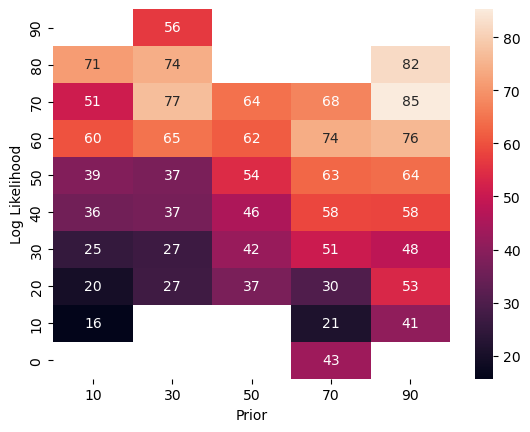

In [96]:
import seaborn as sns
# print(prior_ratio)
# print(like_ratio)

# plt.plot(like_ratio)


data['Log_likelihood_for_left']

step = (np.max(data['Log_likelihood_for_left'])-np.min(data['Log_likelihood_for_left']))/10

for i in range(10):
    data.loc[data['Log_likelihood_for_left'] >i*step+np.min(data['Log_likelihood_for_left']), 'Likelihood'] = i*10


print(np.min(data['Likelihood']))

data2d = pd.DataFrame(columns=[10,30,50,70,90],index=[0,10,20,30,40,50,60,70,80,90])
for pri in [10,30,50,70,90]:
    for lik in [0,10,20,30,40,50,60,70,80,90]:
        temp = data[data['prior']==pri]
        if lik in temp['Likelihood'].values:
            temp2 = temp[temp['Likelihood']==lik]
            data2d.loc[lik,pri] = np.mean(temp2['posterior'])
        else:
            data2d.loc[lik,pri] = 0
data2d.replace(0, float('nan'), inplace=True)
ax = sns.heatmap(data2d, annot=True)
ax.invert_yaxis()
plt.xlabel('Prior')
plt.ylabel('Log Likelihood')


/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_82404/3030789956.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2d.replace(0, float('nan'), inplace=True)


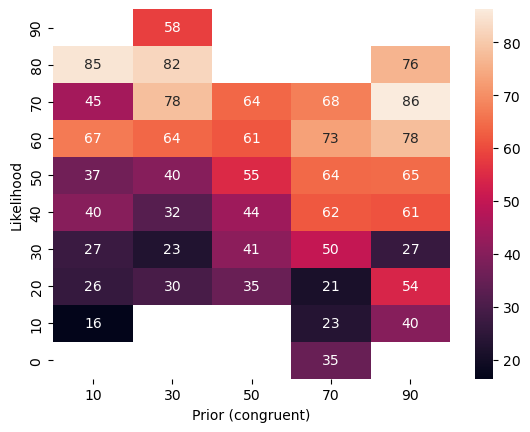

In [100]:
# Group
data2d = pd.DataFrame(columns=[10,30,50,70,90],index=[0,10,20,30,40,50,60,70,80,90])
sub_data = data[data['group']=='control']
#     print(sub_data)
for pri in [10,30,50,70,90]:
    for lik in [0,10,20,30,40,50,60,70,80,90]:
        temp = sub_data[sub_data['prior']==pri]
#         print(pri)
#         print(temp['Likelihood'])
        if lik in temp['Likelihood'].values:

            temp2 = temp[temp['Likelihood']==lik]
            data2d.loc[lik,pri] = np.mean(temp2['posterior'])
        else:
            data2d.loc[lik,pri] = 0
data2d.replace(0, float('nan'), inplace=True)
ax = sns.heatmap(data2d, annot=True)
ax.invert_yaxis()
plt.xlabel('Prior (congruent)')
plt.ylabel('Likelihood')
plt.show()

In [ ]:
# for i in range(10):
#     data.loc[data['correct_image'] >i*10-5, 'Likelihood'] = i*10
    
    
    
    
data2d_log = pd.DataFrame(columns=[10,30,50,70,90],index=[30,40,50,60,70,80,90])
temp = data[data['congruency']==10]
# prior
Lp = np.log(0.1/0.9)
p =  np.exp(Lp)/(1+np.exp(Lp))
# likelihood
lik = temp['correct_image']/100
Ls = np.log(lik/(1-lik))
s = np.exp(Ls)/(1+np.exp(Ls))
# posterior
pos = temp['correct_rate']


In [ ]:
#実際の被験者の行動
pri = data['congruency']/100
Lp = np.log(pri/(1-pri))

lik = data['correct_image']/100
Ls = np.log(lik/(1-lik))# - 0.25*Lp 
s = np.exp(Ls)/(1+np.exp(Ls))
data['log_lik'] = s*100

for i in range(10):
    data.loc[data['log_lik'] >i*10-5, 'Likelihood'] = i*10 
data2d = pd.DataFrame(columns=[10,30,50,70,90],index=[30,40,50,60,70,80,90])
for pri in [10,30,50,70,90]:
    for lik in [30,40,50,60,70,80,90]:
        temp = data[data['congruency']==pri]
        if lik in temp['Likelihood'].values:
            temp2 = temp[temp['Likelihood']==lik]
            data2d.loc[lik,pri] = np.mean(temp2['correct_rate'])
        else:
            data2d.loc[lik,pri] = 0
data2d.replace(0, float('nan'), inplace=True)
ax = sns.heatmap(data2d, annot=True)
ax.invert_yaxis()
plt.xlabel('Prior (congruent)')
plt.ylabel('Likelihood')

In [ ]:
#こっちはsimple Bayesの行動
data2d = pd.DataFrame(columns=[10,30,50,70,90],index=[30,40,50,60,70,80,90])
for pri in [10,30,50,70,90]:
    for lik in [30,40,50,60,70,80,90]:
        temp = data[data['congruency']==pri]
        if lik in temp['Likelihood'].values:
            temp2 = temp[temp['Likelihood']==lik]
            log_value =  np.log(0.01*pri/(1- 0.01*pri)) +  np.log(0.01*lik/(1- 0.01*lik))
            v = np.exp(log_value)/(1+np.exp(log_value))
            data2d.loc[lik,pri] = 100*v
        else:
            data2d.loc[lik,pri] = 0
data2d.replace(0, float('nan'), inplace=True)
ax = sns.heatmap(data2d, annot=True)
ax.invert_yaxis()
plt.xlabel('Prior (congruent)')
plt.ylabel('Likelihood')

In [124]:
sub_list = []
# number_sub = 21
number_sub=1
sigma = 0
for subject_number in range(number_sub):
#     print(subject_number)
    sub_data = data[data['subject']==subject_number]
    prior_list = np.zeros(100)
    left_like_lis = np.zeros(100)
    right_like_lis = np.zeros(100)
    c_list = np.zeros(100)
    print(sub_data)

    
    for trial in range(100):
        prior_list[trial] = sub_data.at[(100*subject_number)+trial,'prior']
        
        #likelihood depends on the corloc
        if sub_data.at[(100*subject_number)+trial,'corloc']==1:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
        elif sub_data.at[(100*subject_number)+trial,'corloc']==2:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']

        c_list[trial] = sub_data.at[(100*subject_number)+trial,'posterior']

    prior_list = [n/100 for n in prior_list]
    left_like_lis = [n/100 for n in left_like_lis]
    right_like_lis = [n/100 for n in right_like_lis]
    c_list = [1 if c==0 else c for c in c_list]
    c_list = [99 if c==100 else c for c in c_list]
    c_list = [n/100 for n in c_list]

    wp = 1
    ws = 1
    alpha_p = 0
    alpha_s = 0
    params = [wp,ws,alpha_p,alpha_s]
    c_estimated = np.zeros(100)
    Lc = np.zeros(100)
    for t in range(100):
        c_estimated[t], Lc[t] = circular_inference(prior_list[t]*100,left_like_lis[t]*100,right_like_lis[t]*100,params)
    
#     plt.plot(likelihood_list,c_estimated)

    prior_ratio = [np.log(prior/(1-prior)) for prior in prior_list]
    like_ratio = [np.log(left/right) for left, right in zip(left_like_lis,right_like_lis)]

    posterior  corloc  prior  imgseq  slider  subject group  correct_rate  \
0        30.0     2.0   30.0    99.0     9.0        0   scz          70.0   
1        10.0     1.0   90.0    32.0    10.0        0   scz          10.0   
2        50.0     1.0   50.0    40.0     2.0        0   scz          50.0   
3        90.0     2.0   90.0    22.0    11.0        0   scz          10.0   
4        10.0     2.0   10.0    34.0     7.0        0   scz          90.0   
..        ...     ...    ...     ...     ...      ...   ...           ...   
95       30.0     1.0   30.0    66.0     7.0        0   scz          30.0   
96       70.0     2.0   70.0    20.0     8.0        0   scz          30.0   
97       10.0     2.0   10.0    57.0     5.0        0   scz          90.0   
98       10.0     2.0   10.0    10.0     5.0        0   scz          90.0   
99       10.0     2.0   10.0    12.0    11.0        0   scz          90.0   

    congruency  correct_image  correct_image_for_left  blur  false_image  


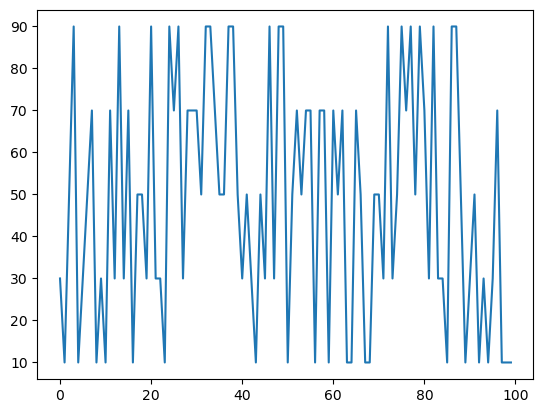

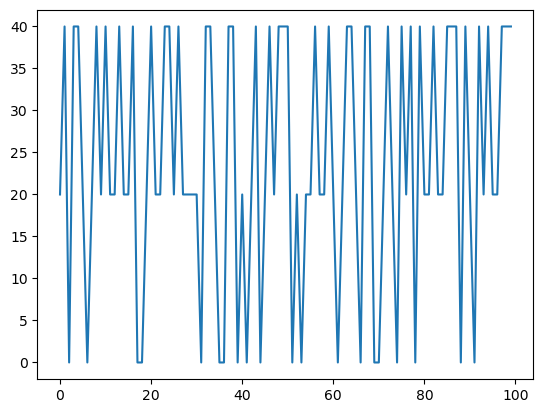

In [125]:

plt.plot(sub_data['posterior'])
plt.show()

plt.plot(abs(sub_data['posterior']-50))

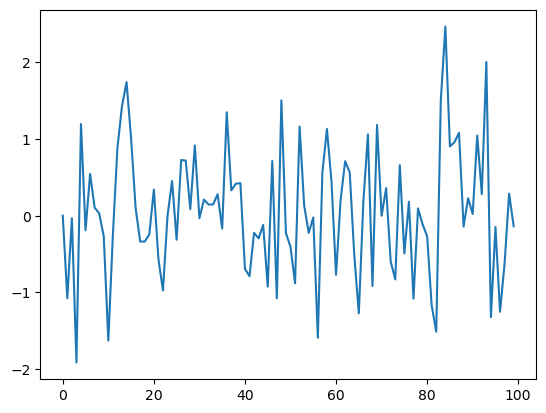

In [129]:
sub_list = []
# number_sub = 21
number_sub=1
sigma = 0
for subject_number in range(number_sub):
#     print(subject_number)_ke
    

    # cm = plt.cm.get_cmap('jet')
    # plt.scatter(like_ratio,c_estimated,c=prior_ratio,cmap=cm)
    # plt.colorbar()
    # plt.xlabel('log likelihood ratio')
    # plt.ylabel('Posterior')
    # plt.show()

In [142]:
data

,posterior,corloc,prior,imgseq,slider,subject,group,correct_rate,congruency,correct_image,correct_image_for_left,blur,false_image,Log_likelihood_for_left
0,30.0,2.0,30.0,99.0,9.0,0,scz,70.0,70.0,18.571429,22.380952,25.0,18.571429,0.000000
1,10.0,1.0,90.0,32.0,10.0,0,scz,10.0,90.0,21.428571,52.380952,20.0,62.857143,-1.076139
2,50.0,1.0,50.0,40.0,2.0,0,scz,50.0,50.0,44.285714,40.952381,30.0,45.714286,-0.031749
3,90.0,2.0,90.0,22.0,11.0,0,scz,10.0,10.0,87.142857,40.952381,25.0,12.857143,-1.913649
4,10.0,2.0,10.0,34.0,7.0,0,scz,90.0,90.0,18.571429,43.333333,20.0,61.428571,1.196251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,30.0,1.0,30.0,66.0,7.0,20,control,30.0,30.0,54.285714,42.380952,30.0,62.857143,-0.146603
2096,0.0,2.0,70.0,20.0,8.0,20,control,100.0,30.0,70.000000,30.476190,10.0,20.000000,-1.252763
2097,0.0,2.0,10.0,57.0,5.0,20,control,100.0,90.0,61.428571,29.047619,25.0,32.857143,-0.625706
2098,10.0,2.0,10.0,10.0,5.0,20,control,90.0,90.0,30.000000,45.714286,40.0,40.000000,0.287682


In [151]:
average_posterior_per_imgseq = data.groupby('imgseq')['posterior'].mean().reset_index()
avg_values_per_imgseq = data.groupby('imgseq').agg({'posterior': 'mean', 'Log_likelihood_for_left': 'mean','Log_likelihood': 'mean','correct_rate': 'mean'}).reset_index()

avg_values_per_imgseq

,imgseq,posterior,Log_likelihood_for_left,Log_likelihood,correct_rate
0,1.0,40.952381,0.037075,-0.111226,75.238095
1,2.0,52.857143,0.129208,0.904456,55.714286
2,3.0,45.714286,-0.387490,1.627456,87.619048
3,4.0,60.952381,0.045660,0.958850,80.952381
4,5.0,62.380952,0.681895,1.591089,89.047619
...,...,...,...,...,...
95,96.0,54.285714,-0.059837,-0.251314,59.047619
96,97.0,60.000000,0.387717,1.163151,71.428571
97,98.0,51.904762,0.037546,-0.788457,39.523810
98,99.0,70.952381,0.000000,0.000000,77.619048


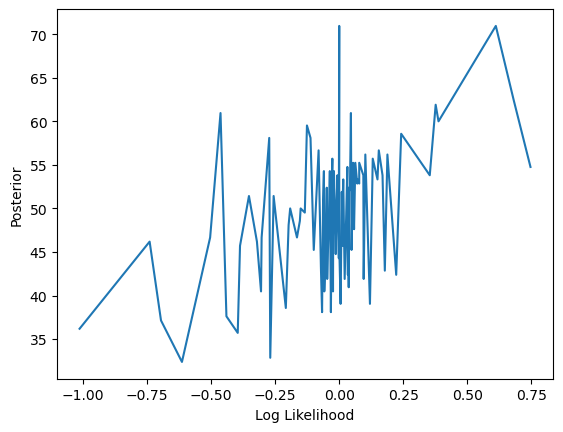

In [152]:
avg_values_sorted = avg_values_per_imgseq.sort_values(by='Log_likelihood_for_left')

plt.plot(avg_values_sorted['Log_likelihood_for_left'], avg_values_sorted['posterior'], linestyle='-')
# plt.title('Posterior vs. Log Likelihood for Left (Sorted by Log Likelihood for Left)')
plt.xlabel('Log Likelihood')
plt.ylabel('Posterior')
plt.show()

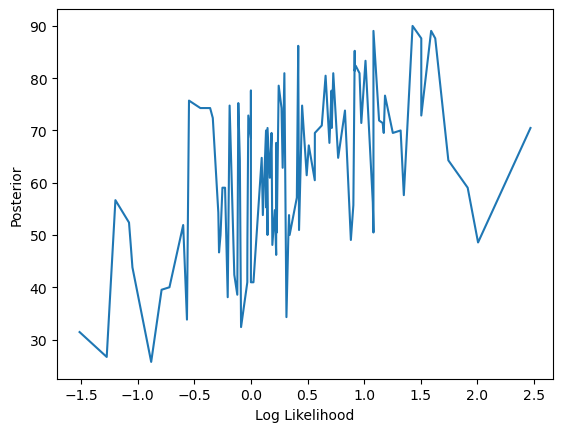

In [153]:
avg_values_sorted = avg_values_per_imgseq.sort_values(by='Log_likelihood')

plt.plot(avg_values_sorted['Log_likelihood'], avg_values_sorted['correct_rate'], linestyle='-')
# plt.title('Posterior vs. Log Likelihood for Left (Sorted by Log Likelihood for Left)')
plt.xlabel('Log Likelihood')
plt.ylabel('Posterior')
plt.show()

In [166]:
dd_scz = data[data['group']=='scz']
# df_with_scz = data.groupby('imgseq')['posterior'].mean().reset_index()
dd_control = data[data['group']=='control']
# df_with_con = data.groupby('imgseq')['posterior'].mean().reset_index()
avg_valuescz = dd_scz.groupby(['imgseq']).agg({'posterior': 'mean', 'Log_likelihood_for_left': 'mean','Log_likelihood': 'mean','correct_rate': 'mean'}).reset_index()
avg_valuecon = dd_control.groupby(['imgseq']).agg({'posterior': 'mean', 'Log_likelihood_for_left': 'mean','Log_likelihood': 'mean','correct_rate': 'mean'}).reset_index()

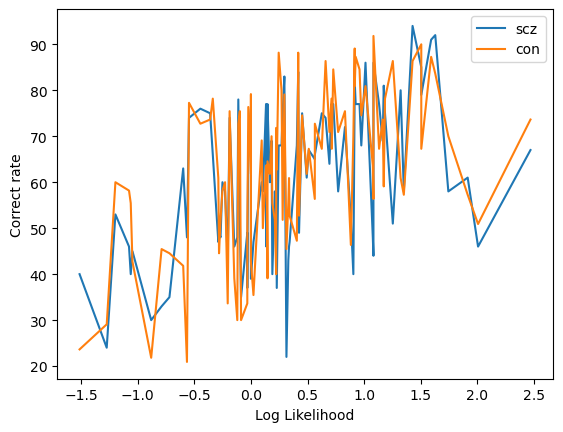

In [172]:
avg_values_sorted_scz = avg_valuescz.sort_values(by='Log_likelihood')
avg_values_sorted_con = avg_valuecon.sort_values(by='Log_likelihood')

plt.plot(avg_values_sorted_scz['Log_likelihood'], avg_values_sorted_scz['correct_rate'], linestyle='-',label='scz')
plt.plot(avg_values_sorted_con['Log_likelihood'], avg_values_sorted_con['correct_rate'], linestyle='-',label='con')
# plt.title('Posterior vs. Log Likelihood for Left (Sorted by Log Likelihood for Left)')
plt.xlabel('Log Likelihood')
plt.ylabel('Correct rate')
plt.legend()
plt.show()